# Perfoming Crop Detection a Count of Leaves

> This is acheived by using **YOLO** object detection framework which make use of **Deep Neural Network** Algorithm to first detect the crop object (weed) followed by a leaf count of the crop 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [2]:
#load the class labels our YOLO model was trained on
labelsPath = '../data/names/obj.names'
LABELS = open(labelsPath).read().strip().split("\n")

In [3]:
#load weights and cfg
weightsPath = '../data/weights/' + 'crop_weed_detection.weights'
configPath = '../data/cfg/crop_weed.cfg'

In [4]:
#color selection for drawing bbox
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

In [5]:
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [13]:
#load our input image and grab its spatial dimensions
image = cv2.imread('../data/images/crop_1.jpeg')
(H, W) = image.shape[:2]

In [14]:
#parameters
confi = 0.5
thresh = 0.5

[INFO] YOLO took 1.238738 seconds


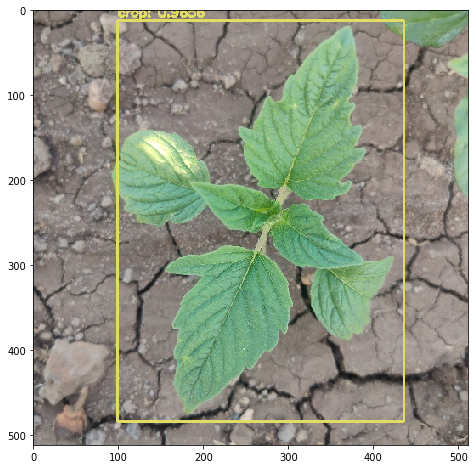

In [15]:
#determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

#construct a blob from the input image and then perform a forward
#pass of the YOLO object detector, giving us our bounding boxes and
#associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (512, 512),swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

#show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

#initialize our lists of detected bounding boxes, confidences, and
#class IDs, respectively
boxes = []
confidences = []
classIDs = []

#loop over each of the layer outputs
for output in layerOutputs:
    #loop over each of the detections
    for detection in output:
        #extract the class ID and confidence (i.e., probability) of
        #the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        #filter out weak predictions by ensuring the detected
        #probability is greater than the minimum probability
        if confidence > confi:
            #scale the bounding box coordinates back relative to the
            #size of the image, keeping in mind that YOLO actually
            #returns the center (x, y)-coordinates of the bounding
            #box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            #use the center (x, y)-coordinates to derive the top and
            #and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            #update our list of bounding box coordinates, confidences,
            #and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

#apply non-maxima suppression to suppress weak, overlapping bounding
#boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confi, thresh)

#ensuring at least one detection exists
if len(idxs) > 0:
    #loop over the indexes we are keeping
    for i in idxs.flatten():
        #extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        #draw a bounding box rectangle and label on the image
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
det = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.imshow(det)

In [9]:
#save detected image 
path = 'detection.jpeg'#change if you want
det = cv2.cvtColor(det,cv2.COLOR_RGB2BGR)
cv2.imwrite(path,det)

True

PRE PROCESSING DATASET OF COMMON CHCKWEED IMAGES

This part of the system extracts weeds from their background and counts the number of leaves

In [1]:
import pandas as pd

ds_path ='C:\\Users\\Annie\\Downloads\\Common Chickweed'
img_files = os.listdir(ds_path)

In [2]:
def create_dataset():
    names=['predicted leaf count']
    df = pd.DataFrame([], columns=names)
    for file in img_files:
        imgpath = ds_path + "\\" + file
        print(imgpath)
        main_img = cv2.imread(imgpath)
        
        #preprocessing
        
        #removing background of images
        hsv = cv2.cvtColor(main_img, cv2.COLOR_BGR2HSV)

        # find the green color 
        mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
        # find the brown color
        mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
        # find the yellow color in the leaf
        mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))

        # find any of the three colors(green or brown or yellow) in the image
        mask = cv2.bitwise_or(mask_green, mask_yellow)
        mask = cv2.bitwise_or(mask, mask_yellow)

        # Bitwise-AND mask and original image
        res = cv2.bitwise_and(main_img,main_img, mask= mask)
        
        
        # Convert image in grayscale
        gray_im = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
       
        
        
        # Contrast adjusting with gamma correction y = 1.2
        gray_correct = np.array(255 * (gray_im / 255) ** 1.2 , dtype='uint8')
       
        
        
        # Local adaptative threshold

        ret_otsu,thresh = cv2.threshold(gray_correct,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        
        
        # Dilatation et erosion
        kernel = np.ones((15,15), np.uint8)
        img_dilation = cv2.dilate(thresh, kernel, iterations=1)
        img_erode = cv2.erode(img_dilation,kernel, iterations=1)
        
        # clean all noise after dilatation and erosion
        img_erode = cv2.medianBlur(img_erode, 7)
        plt.subplot(221)
        
        #Labelling
        ret, labels = cv2.connectedComponents(img_erode)
        label_hue = np.uint8(179 * labels / np.max(labels))
        blank_ch = 255 * np.ones_like(label_hue)
        labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
        labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
        #labeled_img[label_hue == 0] = 0
        
        count=ret-1
        
        vector=[count]
        df_temp = pd.DataFrame([vector],columns=names)
        df = df.append(df_temp)
        print(file)
    return df



        
        

C:\Users\Annie\Downloads\Common Chickweed\1.png
1.png
C:\Users\Annie\Downloads\Common Chickweed\10.png
10.png
C:\Users\Annie\Downloads\Common Chickweed\100.png
100.png
C:\Users\Annie\Downloads\Common Chickweed\101.png
101.png
C:\Users\Annie\Downloads\Common Chickweed\102.png
102.png
C:\Users\Annie\Downloads\Common Chickweed\103.png
103.png
C:\Users\Annie\Downloads\Common Chickweed\104.png
104.png
C:\Users\Annie\Downloads\Common Chickweed\105.png
105.png
C:\Users\Annie\Downloads\Common Chickweed\106.png
106.png
C:\Users\Annie\Downloads\Common Chickweed\107.png
107.png
C:\Users\Annie\Downloads\Common Chickweed\108.png
108.png
C:\Users\Annie\Downloads\Common Chickweed\109.png
109.png
C:\Users\Annie\Downloads\Common Chickweed\11.png


<ipython-input-2-53fde7a1713f>:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(221)


11.png
C:\Users\Annie\Downloads\Common Chickweed\110.png
110.png
C:\Users\Annie\Downloads\Common Chickweed\111.png
111.png
C:\Users\Annie\Downloads\Common Chickweed\112.png
112.png
C:\Users\Annie\Downloads\Common Chickweed\113.png
113.png
C:\Users\Annie\Downloads\Common Chickweed\114.png
114.png
C:\Users\Annie\Downloads\Common Chickweed\115.png
115.png
C:\Users\Annie\Downloads\Common Chickweed\116.png
116.png
C:\Users\Annie\Downloads\Common Chickweed\117.png
117.png
C:\Users\Annie\Downloads\Common Chickweed\118.png
118.png
C:\Users\Annie\Downloads\Common Chickweed\119.png
119.png
C:\Users\Annie\Downloads\Common Chickweed\12.png
12.png
C:\Users\Annie\Downloads\Common Chickweed\120.png
120.png
C:\Users\Annie\Downloads\Common Chickweed\121.png
121.png
C:\Users\Annie\Downloads\Common Chickweed\122.png
122.png
C:\Users\Annie\Downloads\Common Chickweed\123.png
123.png
C:\Users\Annie\Downloads\Common Chickweed\124.png
124.png
C:\Users\Annie\Downloads\Common Chickweed\125.png
125.png
C:\Users\

264.png
C:\Users\Annie\Downloads\Common Chickweed\265.png
265.png
C:\Users\Annie\Downloads\Common Chickweed\266.png
266.png
C:\Users\Annie\Downloads\Common Chickweed\267.png
267.png
C:\Users\Annie\Downloads\Common Chickweed\268.png
268.png
C:\Users\Annie\Downloads\Common Chickweed\269.png
269.png
C:\Users\Annie\Downloads\Common Chickweed\27.png
27.png
C:\Users\Annie\Downloads\Common Chickweed\270.png
270.png
C:\Users\Annie\Downloads\Common Chickweed\271.png
271.png
C:\Users\Annie\Downloads\Common Chickweed\272.png
272.png
C:\Users\Annie\Downloads\Common Chickweed\273.png
273.png
C:\Users\Annie\Downloads\Common Chickweed\274.png
274.png
C:\Users\Annie\Downloads\Common Chickweed\275.png
275.png
C:\Users\Annie\Downloads\Common Chickweed\276.png
276.png
C:\Users\Annie\Downloads\Common Chickweed\277.png
277.png
C:\Users\Annie\Downloads\Common Chickweed\278.png
278.png
C:\Users\Annie\Downloads\Common Chickweed\279.png
279.png
C:\Users\Annie\Downloads\Common Chickweed\28.png
28.png
C:\Users\A

399.png
C:\Users\Annie\Downloads\Common Chickweed\4.png
4.png
C:\Users\Annie\Downloads\Common Chickweed\40.png
40.png
C:\Users\Annie\Downloads\Common Chickweed\400.png
400.png
C:\Users\Annie\Downloads\Common Chickweed\401.png
401.png
C:\Users\Annie\Downloads\Common Chickweed\402.png
402.png
C:\Users\Annie\Downloads\Common Chickweed\403.png
403.png
C:\Users\Annie\Downloads\Common Chickweed\404.png
404.png
C:\Users\Annie\Downloads\Common Chickweed\405.png
405.png
C:\Users\Annie\Downloads\Common Chickweed\406.png
406.png
C:\Users\Annie\Downloads\Common Chickweed\407.png
407.png
C:\Users\Annie\Downloads\Common Chickweed\408.png
408.png
C:\Users\Annie\Downloads\Common Chickweed\409.png
409.png
C:\Users\Annie\Downloads\Common Chickweed\41.png
41.png
C:\Users\Annie\Downloads\Common Chickweed\410.png
410.png
C:\Users\Annie\Downloads\Common Chickweed\411.png
411.png
C:\Users\Annie\Downloads\Common Chickweed\412.png
412.png
C:\Users\Annie\Downloads\Common Chickweed\413.png
413.png
C:\Users\Annie

529.png
C:\Users\Annie\Downloads\Common Chickweed\53.png
53.png
C:\Users\Annie\Downloads\Common Chickweed\530.png
530.png
C:\Users\Annie\Downloads\Common Chickweed\531.png
531.png
C:\Users\Annie\Downloads\Common Chickweed\532.png
532.png
C:\Users\Annie\Downloads\Common Chickweed\533.png
533.png
C:\Users\Annie\Downloads\Common Chickweed\534.png
534.png
C:\Users\Annie\Downloads\Common Chickweed\535.png
535.png
C:\Users\Annie\Downloads\Common Chickweed\536.png
536.png
C:\Users\Annie\Downloads\Common Chickweed\537.png
537.png
C:\Users\Annie\Downloads\Common Chickweed\538.png
538.png
C:\Users\Annie\Downloads\Common Chickweed\539.png
539.png
C:\Users\Annie\Downloads\Common Chickweed\54.png
54.png
C:\Users\Annie\Downloads\Common Chickweed\540.png
540.png
C:\Users\Annie\Downloads\Common Chickweed\541.png
541.png
C:\Users\Annie\Downloads\Common Chickweed\542.png
542.png
C:\Users\Annie\Downloads\Common Chickweed\543.png
543.png
C:\Users\Annie\Downloads\Common Chickweed\544.png
544.png
C:\Users\A

664.png
C:\Users\Annie\Downloads\Common Chickweed\665.png
665.png
C:\Users\Annie\Downloads\Common Chickweed\666.png
666.png
C:\Users\Annie\Downloads\Common Chickweed\667.png
667.png
C:\Users\Annie\Downloads\Common Chickweed\668.png
668.png
C:\Users\Annie\Downloads\Common Chickweed\669.png
669.png
C:\Users\Annie\Downloads\Common Chickweed\67.png
67.png
C:\Users\Annie\Downloads\Common Chickweed\670.png
670.png
C:\Users\Annie\Downloads\Common Chickweed\671.png
671.png
C:\Users\Annie\Downloads\Common Chickweed\672.png
672.png
C:\Users\Annie\Downloads\Common Chickweed\674.png
674.png
C:\Users\Annie\Downloads\Common Chickweed\675.png
675.png
C:\Users\Annie\Downloads\Common Chickweed\676.png
676.png
C:\Users\Annie\Downloads\Common Chickweed\677.png
677.png
C:\Users\Annie\Downloads\Common Chickweed\678.png
678.png
C:\Users\Annie\Downloads\Common Chickweed\679.png
679.png
C:\Users\Annie\Downloads\Common Chickweed\68.png
68.png
C:\Users\Annie\Downloads\Common Chickweed\680.png
680.png
C:\Users\A

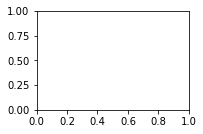

In [3]:
dataset = create_dataset()

In [4]:
dataset.shape

(713, 1)

In [6]:
type(dataset)

pandas.core.frame.DataFrame

In [7]:
dataset.sample(20)

,Unnamed: 0,predicted leaf count,actual leaf count
354,0,2,4
577,0,3,4
392,0,3,4
666,0,1,4
560,0,1,4
533,0,1,4
437,0,1,4
710,0,9,10
689,0,2,2
222,0,1,2


In [10]:
dataset.to_csv("WeedDataset.csv")

K NEAREST NEIGHBORS CLASSIFICATION

In [8]:
import datetime
import pickle
from PIL import Image
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [9]:
df = pd.read_csv('C:\\Users\\Annie\\WeedDataset2.csv')

In [10]:
df['avg'] = df.apply(lambda x: (x['predicted leaf count']+x['actual leaf count'])/2, axis=1)

In [11]:
df.sample(10)

,Unnamed: 0,predicted leaf count,actual leaf count,avg
154,0,1,2,1.5
288,0,2,2,2.0
155,0,1,2,1.5
295,0,2,2,2.0
693,0,2,4,3.0
145,0,1,2,1.5
625,0,1,2,1.5
666,0,1,4,2.5
494,0,1,3,2.0
339,0,2,2,2.0


A scatter plot showing the predicted leaf count against the actual leaf count

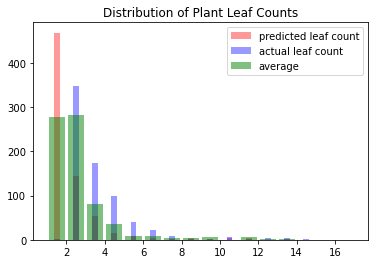

In [12]:
plt.hist(df['predicted leaf count'], bins=[i for i in range(1, 18)], color='r', alpha=0.4, rwidth=0.3, label='predicted leaf count')
plt.hist(df['actual leaf count'], bins=[i for i in range(1, 18)], color='b', alpha=0.4, rwidth=0.3, label='actual leaf count')
plt.hist(df.avg, bins=[i for i in range(1, 18)], color='g', alpha=0.5, rwidth=0.85, label='average')
plt.legend(loc='upper right')
plt.title('Distribution of Plant Leaf Counts')
plt.show()

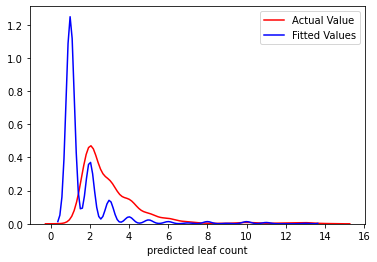

In [13]:
Y=df['actual leaf count']
Yhat=df['predicted leaf count']
ax1 = sns.distplot(Y, hist=False, color="r", label="Actual Value")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)

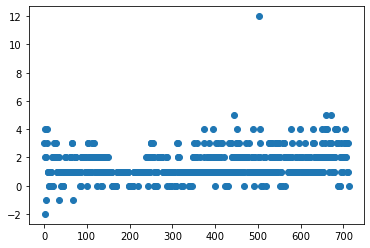

In [14]:
g=plt.plot(Y - Yhat,marker='o',linestyle='')

In [15]:
import math
mse = sklearn.metrics.mean_squared_error(Y, Yhat)
rmse = math.sqrt(mse)
print('Root mean square error:',rmse)

Root mean square error: 1.781941516442793
